# Womanium 2024 - Assignment 6.12
## Quantum Random Walk


In [1]:
import classiq

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Instructions - Final Assignment
Follow the example from the 4th session for creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes.

Create a well-detailed Python Jupyter notebook that explains your algorithm, including the code parts covered in class, and pictures/figures where relevant. Utilize the attached Python code (quantum_walk_circle_example.py) with the example from class for the task. Feel free to extend the example beyond the requirements here and what was covered in class.

Contribute your notebook to the Classiq Git Library to the folder community/womanium/assignments Follow the contribution guidelines in order to contribute - NO need to open an issue for this, you can directly open a PR

## Implementation
Given is a Python Jupyter notebook containing the algorithm of a quantum walk operator for a circle with 4 nodes. This has to to be extended to allow a quantum random walk on a line with 16 nodes using the Classiq platform.

To extend the provided quantum walk operator for a circle with 4 nodes to a line with 16 nodes, we need to adjust the register sizes and modify the _**W_iteration**_ function and the _**edge_oracle**_ function to handle the appropriate adjacency rules and transition probabilities for each case.

The **edge_oracle function** places a constraint on which steps are allowed by checking the adjacency of any two vertices. 
- It has to take into account that in a <u>circle</u> the first node 0 and the last node n-1 are adjacent (where n is the number of nodes).
- This wrap-around characteristic does not appear in a <u>line</u>.

The **W_iteration function** contains the transition probabilities between the various nodes. 
- In a <u>circle</u> the probabilities of transition between any two adjacent vertices is 0.5. 
- The probabilities for the first node 0 and the last node n-1 in a <u>line</u> is different from those between any intermediate nodes (where n is the number of nodes). For the first and last node in a line, only one transition is possible to the only one adjacent node with probability 1.

_**So the code differs in the two functions <u>edge_oracle</u> and <u>W_iteration</u>, depending on whether one is dealing with a circle or a line.**_

Below are the implementations for circles with 4, 8, and 16 nodes and for lines with 4, 8, and 16 nodes, respectively.


In all cases, the main function initializes the quantum registers, applies the Hadamard transform to create a superposition, and then applies the W and S operators to perform the quantum walk.


## Functions used in this notebook


    
    
### Explanation

1. **prepare_minus Function**: This function prepares a minus state for a given qubit by applying the X gate followed by the Hadamard gate.

2. **diffuser_oracle Function**: This function marks solutions using the diffuser oracle, setting the auxiliary qubit based on the condition ( x != 0 ).

3. **zero_diffuser Function**: This function creates a zero diffuser using Grover's algorithm technique, which involves preparing a minus state and applying the diffuser oracle.

4. _<u>**W_iteration Function**</u>_: This function performs a single iteration of the W operator for the circle/line with 4, 8, 16 nodes. It calculates the probability vector for the adjacent vertices and applies the zero diffuser.

5. **W_operator Function**: This function iterates over all possible states and applies the W_iteration function.

6. _<u>**edge_oracle Function**</u>_: This function checks the adjacency of vertices in a quantum walk and sets the result qubit accordingly.

7. **bitwise_swap Function**: This function performs a bitwise swap between two qubit arrays, thereby moving the current node.

8. **S_operator Function** (shift operator): This function applies the edge oracle and performs a conditional swap operation based on the result qubit. It performs the actual shift from one vertex to the next.

9. **main Function**: This function allocates the required qubits, applies the Hadamard transform, and then applies the W_operator and S_operator functions to simulate the quantum walk.

10. **Creating and Synthesizing the Quantum Model**: Finally, we create the quantum model, synthesize the quantum program, and display the result.


# Transpiled qubits vs. number of nodes

This table summarizes the various runs done on the classiq platform (see below), i.e., random walks with 4, 8, and 16 nodes on both circles and lines.

More nodes need more transpiled qubits. It appears that lines need slightly more qubits (and more depth) than circles for a given number of nodes.

| **<u>Random walk - circle/line</u>** | **nodes** | **qubits** | **depth** |
| :------ | :-------: | :-------: | :-------: |
| circle | 4  | 13 | 187 |
| line | 4 | 17 | 342 |
| circle | 8 | 22| 703 |
| line | 8 | 25 | 783 |
| circle | 16 | 33 | 2942 |
| line | 16 | 33 | 3040 |






# Circle with 4 Nodes:

The size of the register is set to 2, which allows for 4 nodes. The <u>W_iteration</u> function calculates the probabilities for the adjacent nodes in a circle.
The <u>W_operator</u> applies W_iteration for all possible states.


In [11]:
from classiq import *

size = 2

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0]*(2**size) #[0,0,0,0]
    
    prob[(i+1)% 4]=0.5
    prob[(i-1)% 4]=0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  diff = vertices - adjacent_vertices
  res |= (diff%(2**size) == 1) | (diff%(2**size) == ((2**size)-1))

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
#show(qprog)

State=0, prob vec =[0, 0.5, 0, 0.5]
State=1, prob vec =[0.5, 0, 0.5, 0]
State=2, prob vec =[0, 0.5, 0, 0.5]
State=3, prob vec =[0.5, 0, 0.5, 0]


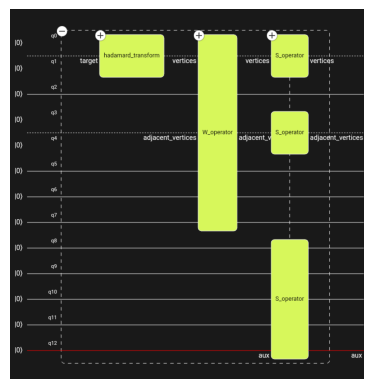

In [3]:
img = mpimg.imread('circle-4.png')
plt.imshow(img)
plt.axis('off')
plt.show()

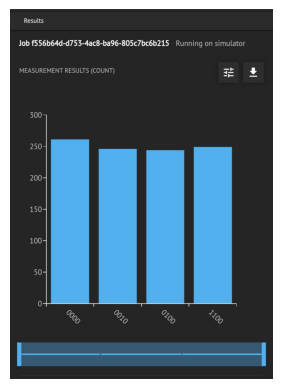

In [4]:
img = mpimg.imread('circle-4.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()


# Circle with 8 Nodes:

The register size is set to 3, which allows for 8 nodes.


In [4]:
from classiq import *

size = 3

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0]*(2**size) #[0,0,0,0]
    
    prob[(i+1)% 4]=0.5
    prob[(i-1)% 4]=0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  diff = vertices - adjacent_vertices
  res |= (diff%(2**size) == 1) | (diff%(2**size) == ((2**size)-1))

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
#show(qprog)

State=0, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=3, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=5, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=7, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0]


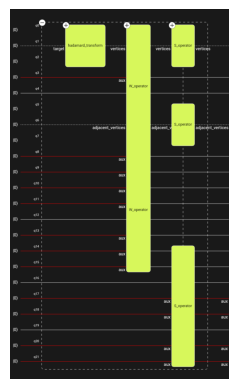

In [6]:
img = mpimg.imread('circle-8.png')
plt.imshow(img)
plt.axis('off')
plt.show()

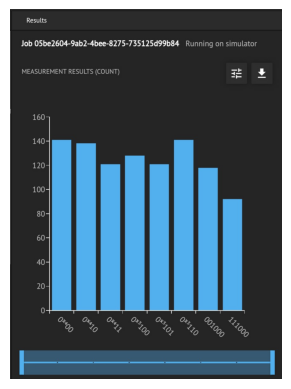

In [5]:
img = mpimg.imread('circle-8.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()


# Circle with 16 Nodes:

The register size is set to 4, which allows for 16 nodes.


In [5]:
from classiq import *

size = 4

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0]*(2**size) #[0,0,0,0]
    
    prob[(i+1)% 4]=0.5
    prob[(i-1)% 4]=0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  diff = vertices - adjacent_vertices
  res |= (diff%(2**size) == 1) | (diff%(2**size) == ((2**size)-1))

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
#show(qprog)

State=0, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=11, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=12, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=13, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

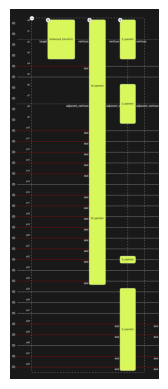

In [7]:
img = mpimg.imread('circle-16.png')
plt.imshow(img)
plt.axis('off')
plt.show()


# Line with 16 Nodes:

<u>W_iteration</u> function calculates the probabilities for the adjacent nodes in a line, taking into account that nodes at the ends only have one adjacent node.
<u>W_operator</u> applies W_iteration for all possible states.


For a line with 16 nodes, we need to adjust the register size to 4 (since 2^4=16) and modify the adjacency rules in edge_oracle accordingly.

In [7]:
from classiq import *

size = 4

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    
    prob = [0] * (2 ** size)
    
    if i == 0:
        prob[i + 1] = 1.0
    elif i == (2 ** size) -1:
        prob[i - 1] = 1.0
    else:
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  diff = vertices - adjacent_vertices
  res |= (diff == 1) | (diff == -1)
  

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
write_qmod(qmod,name="line16")

qprog = synthesize(qmod)
#show(qprog)

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

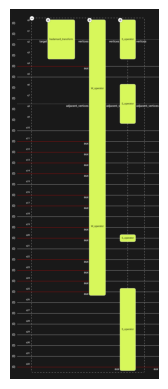

In [8]:
img = mpimg.imread('line-16.png')
plt.imshow(img)
plt.axis('off')
plt.show()


# Line with 4 Nodes:

The register size is set to 2, which allows for 4 nodes.


In [9]:
from classiq import *

size = 2

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    
    prob = [0] * (2 ** size)
    
    if i == 0:
        prob[i + 1] = 1.0
    elif i == (2 ** size) -1:
        prob[i - 1] = 1.0
    else:
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  diff = vertices - adjacent_vertices
  res |= (diff == 1) | (diff == -1)
  

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
write_qmod(qmod,name="line16")

qprog = synthesize(qmod)
#show(qprog)

State=0, prob vec =[0, 1.0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0]
State=2, prob vec =[0, 0.5, 0, 0.5]
State=3, prob vec =[0, 0, 1.0, 0]


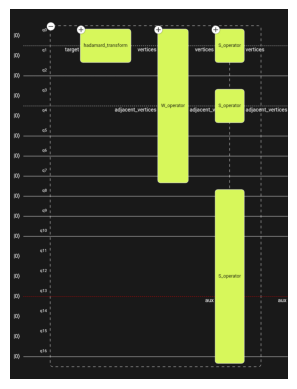

In [9]:
img = mpimg.imread('line-4.png')
plt.imshow(img)
plt.axis('off')
plt.show()

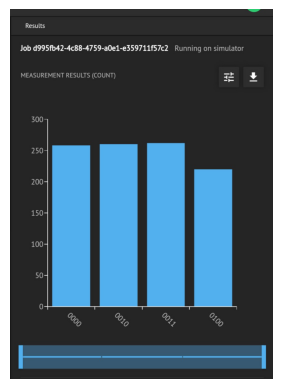

In [10]:
img = mpimg.imread('line-4.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()


# Line with 8 Nodes:

The qubit register size is set to 3, which allows for 8 nodes.


In [10]:
from classiq import *

size = 3

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    
    prob = [0] * (2 ** size)
    
    if i == 0:
        prob[i + 1] = 1.0
    elif i == (2 ** size) -1:
        prob[i - 1] = 1.0
    else:
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  diff = vertices - adjacent_vertices
  res |= (diff == 1) | (diff == -1)
  

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
write_qmod(qmod,name="line16")

qprog = synthesize(qmod)
#show(qprog)

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 1.0, 0]


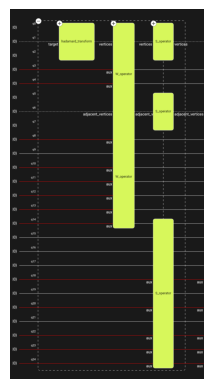

In [11]:
img = mpimg.imread('line-8.png')
plt.imshow(img)
plt.axis('off') 
plt.show()

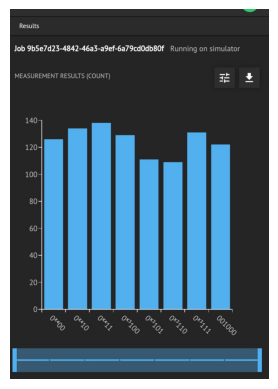

In [12]:
img = mpimg.imread('line-8.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

eof